In [1]:
#Reference-https://www.tensorflow.org/get_started/mnist/pros

#Loading required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.INFO)
import matplotlib.pyplot as plt
import scipy.signal



# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

np.random.seed(0)


In [2]:
def imgs_iterator(data,labels,batchSize):
    startIndex= 0
    totalSize = len(data)
    indices = np.arange(totalSize)
    np.random.shuffle(indices)
    
    for i in range(0,totalSize,batchSize):
            batchIndices = indices[i:i+batchSize]
            yield np.stack(data[batchIndices]),labels[batchIndices],len(batchIndices)
            
def imgs_iterator_predict(data,batchSize):
    startIndex= 0
    totalSize = len(data)
    indices = np.arange(totalSize)
    np.random.shuffle(indices)
    
    for i in range(0,totalSize,batchSize):
        batchIndices = indices[i:i+batchSize]
        
        yield np.stack(data[batchIndices]),len(batchIndices)

def make_predictions(data,batch_size):
    predictions_mb=[]
    #Test- Predictions:
    iter_test = imgs_iterator_predict(data,batch_size)
    try:
        next_batch =iter_test.__next__()
        while next_batch!=None:
            mini_batch,batch_size = next_batch
            #print (test_mini_batch)
            mini_batch = np.reshape(mini_batch,(batch_size,9216))
            feed_dict = {x: np.stack(mini_batch), keep_prob: 1.0}
            predictions = y.eval(feed_dict)
            predictions_mb.append(predictions)
            next_batch =iter_test.__next__()
    except StopIteration:
        next_batch=None
    results = pd.DataFrame(np.vstack(predictions_mb))
    
    return results
#imgs_iterator_predict(test["Image"],100)

def generate_results(result):
    submission = pd.read_csv('/home/ubuntu/FacialKeypoints/data/SampleSubmission.csv')
    IdLookup = pd.read_csv('/home/ubuntu/FacialKeypoints/data/IdLookupTable.csv')
    IdLookupDict = IdLookup.set_index('RowId').T.to_dict('list')

    
    
    result.columns = column_names[0:30]
    output = pd.concat([test["ImageId"],result],axis=1)
    
    RowId = np.asarray(submission["RowId"],dtype=int)
    for row in RowId:
        r = IdLookupDict[row][0]-1
        c =IdLookupDict[row][1]
        submission.loc[row-1,"Location"]= max(0,min(96,(output.loc[r,c])))
    
    
    submission.to_csv("submission.csv",index=False)
        

In [4]:
# Some additional work to improve accuracy: blur images, move images
#flips images horizontally
def flip_images(inputdata):
    data=inputdata.copy()
    origcols = list(data.columns)
    newcols = [item for item in origcols]
    
    #print data.head()
    for col in data.columns.get_level_values(0)[0:30:2]:
            data[col]=data[col].apply(lambda x: -x)
    
    flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]
    
    for (a,b) in flip_indices:
        newcols[a],newcols[b] = newcols[b],newcols[a]

    colmap = {}
    for i in range(len(newcols)):
        colmap[origcols[i]]=newcols[i]
    
    data = data[newcols]
    data.rename(columns = colmap,inplace=True)
    #print data.head()

    
    data["Image"] = data["Image"].apply(lambda x: np.fliplr(x.reshape((96,96))).flatten())

    return data


def blur_images(inputdata):
    data=inputdata.copy()
    data["Image"] = data["Image"].apply(lambda x: (scipy.signal.convolve2d(x.reshape((96,96)),np.ones((3,3)), mode='same',boundary="fill")/9.0).ravel() )
    return data

def move_images(inputdata,pixels,orientation):
    #pixels= 5 
    #orientation = 'right'
    data = train.copy()
    (dimx,dimy) = (96,96)
    if orientation == 'right':
        padding = np.zeros((dimx,pixels))
        for i in range(padding.shape[0]):
            for j in range(padding.shape[1]):
                random = np.random.normal(0.5,0.1)
                padding[i][j]= min(max(random,0),1)
                
        data["Image"] = data["Image"].apply(lambda x: np.hstack((padding,x.reshape(96,96)))[:,0:96])
    
        for col in data.columns.get_level_values(0)[0:30:2]:
            data[col]=data[col].apply(lambda x: min(96,x+pixels))
    elif orientation == 'left':
        padding = np.zeros((dimx,pixels))
        for i in range(padding.shape[0]):
            for j in range(padding.shape[1]):
                random = np.random.normal(0.5,0.1)
                padding[i][j]= min(max(random,0),1)
        data["Image"] = data["Image"].apply(lambda x: np.hstack((x.reshape(96,96),padding))[:,pixels:96+pixels])
    
        for col in data.columns.get_level_values(0)[0:30:2]:
            data[col]=data[col].apply(lambda x: max(0,x-pixels))
    elif orientation == 'up':
        padding = np.zeros((pixels,dimy))
        for i in range(padding.shape[0]):
            for j in range(padding.shape[1]):
                random = np.random.normal(0.5,0.1)
                padding[i][j]= min(max(random,0),1)
                
        data["Image"] = data["Image"].apply(lambda x: np.vstack((x.reshape(96,96),padding))[pixels:96+pixels,:])
    
        for col in data.columns.get_level_values(0)[1:30:2]:
            data[col]=data[col].apply(lambda x: max(0,x-pixels))
    elif orientation == 'down':
        padding = np.zeros((pixels,dimy))
        for i in range(padding.shape[0]):
            for j in range(padding.shape[1]):
                random = np.random.normal(0.5,0.1)
                padding[i][j]= min(max(random,0),1)
                
        data["Image"] = data["Image"].apply(lambda x: np.vstack((padding,x.reshape(96,96)))[0:96,:])
    
        for col in data.columns.get_level_values(0)[1:30:2]:
            data[col]=data[col].apply(lambda x: min(96,x+pixels))
    
    data["Image"] = data["Image"].apply(lambda x:x.flatten())
    
    return data
    
    

    


In [8]:
#Loading the test and raw training datasets
raw_orig = pd.read_csv('/home/ubuntu/FacialKeypoints/data/training.csv')
test_orig = pd.read_csv('/home/ubuntu/FacialKeypoints/data/test.csv')

#Converting image data into numpy arrays and scaling the images
raw_orig["Image"] = raw_orig["Image"].apply(lambda x: np.asarray(x.split(" "),dtype=np.float32)/255)
test_orig["Image"] = test_orig["Image"].apply(lambda x: np.asarray(x.split(" "),dtype=np.float32)/255)

for col in raw_orig.columns.get_level_values(0)[0:30]:
    raw_orig[col] = raw_orig[col].apply(lambda x: (x-48)/48)

column_names =raw_orig.columns


test_size = int(test_orig.shape[0])

result_test = np.zeros((test_size,30))


In [9]:
raw_orig = pd.concat([raw_orig,flip_images(raw_orig)],axis=0)
raw_orig = raw_orig.sample(frac=1)
#,move_images(train,15,"right"),move_images(train,15,"left")
                  #,move_images(train,15,"up"),move_images(train,15,"down")

raw_orig.reset_index(inplace=True,drop=True)

In [ ]:
for index in range(0,30,2):    #index=0
    
    raw = raw_orig.copy()
    test = test_orig.copy()
    
    raw = raw.sample(frac=1)

    raw=raw[~pd.isnull(raw[raw.columns.get_level_values(0)[index]])]
    raw=raw[~pd.isnull(raw[raw.columns.get_level_values(0)[index+1]])]
    
    train_size = int(raw.shape[0]*.8)


    raw.reset_index(inplace=True,drop=True)
    test.reset_index(inplace=True,drop=True)

    


    train = pd.concat([raw.iloc[0:train_size,[index,index+1]],raw.iloc[0:train_size,30]],axis=1)
    dev = pd.concat([raw.iloc[train_size:raw.shape[0],[index,index+1]],raw.iloc[train_size:raw.shape[0],30]],axis=1)
    train.reset_index(inplace=True,drop=True)
    dev.reset_index(inplace=True,drop=True)

    #prepping test data using transformations
    print ("Training: "+column_names[index])
    train_data = train["Image"].as_matrix()
    train_labels = np.asarray(train.iloc[:,[0,1]]).astype(dtype = np.float32)


    dev_data = dev["Image"].as_matrix()
    dev_labels = np.asarray(dev.iloc[:,[0,1]]).astype(dtype = np.float32)


    test_data = test["Image"].as_matrix()


    #4 convolutional layers and one fully connected layer

    mini_batch_size=300
    epochs = 200

    def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial)

    def bias_variable(shape):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial)

    def conv2d(x, W):
        return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

    def max_pool_2x2(x):
        return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')

    #sess = tf.InteractiveSession()

    #Input
    x = tf.placeholder(tf.float32, shape=[None, 9216])
    y_ = tf.placeholder(tf.float32, shape=[None, 2])

    x_image = tf.reshape(x, [-1,96,96,1])#-1 because we don't know the batch size yet.

    #
    W_conv1 = weight_variable([5, 5, 1, 32])
    b_conv1 = bias_variable([32])

    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1) #returns a 48*48 image with 32 filters

    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])

    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2) #returns a 24*24 image with 64 filters

    #start
    W_conv3 = weight_variable([5, 5, 64, 128])
    b_conv3 = bias_variable([128])

    h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
    h_pool3 = max_pool_2x2(h_conv3) #returns a 12*12 image with 128 filters

    #end


    W_fc1 = weight_variable([12 * 12 * 128, 1024])
    b_fc1 = bias_variable([1024])

    h_pool3_flat = tf.reshape(h_pool3, [-1, 12*12*128])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)

    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    W_fc2 = weight_variable([1024, 2])
    b_fc2 = bias_variable([2])



    #sess.run(tf.global_variables_initializer())

    y = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
    #y = tf.matmul(x,W) + b


    error = tf.sqrt(tf.reduce_mean(tf.square(tf.sub(y_,y))))


    train_step = tf.train.AdamOptimizer(1e-2).minimize(error)

    #with tf.Session() as sess:
    #    sess.run(train_step, feed_dict={x: train_data, y_: train_labels})

    epoch=[i for i in range(1,epochs,10)]
    train_error = []
    dev_error = []

    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(epochs):
            iter_ = imgs_iterator(train_data,train_labels,mini_batch_size-1)
            try:
                next_batch =iter_.__next__()
                while next_batch!=None:
                    train_data_instance,train_label_instance,batch_size = next_batch
                    train_instance = np.reshape(train_data_instance,(batch_size,9216))
                    train_label_instance = np.reshape(train_label_instance,(batch_size,2))
                    train_accuracy = error.eval(feed_dict={x: train_instance, y_: train_label_instance, keep_prob: 1.0})

                    sess.run(train_step,feed_dict={x: train_instance, y_: train_label_instance, keep_prob: 0.5})
                    next_batch =iter_.__next__()
            except StopIteration:
                next_batch=None

            if i%10==0:
                print ("RMSE for Epoch "+str(i)+str(" =")+str(train_accuracy))
                train_error.append(train_accuracy)


            iter_dev = imgs_iterator(dev_data,dev_labels,mini_batch_size-1)
            next_batch =iter_dev.__next__()
            dev_data_instance,dev_label_instance,batch_size = next_batch
            dev_instance = np.reshape(dev_data_instance,(batch_size,9216))
            dev_label_instance = np.reshape(dev_label_instance,(batch_size,2))
            dev_accuracy = error.eval(feed_dict={x: dev_instance, y_: dev_label_instance, keep_prob: 1.0})
            if i%10==0:
                print ("RMSE for dev set ="+str(dev_accuracy))
                dev_error.append(dev_accuracy)



        #Predictions:
        #pred_train =make_predictions(train_data, mini_batch_size-1)
        #pred_dev =make_predictions(dev_data, mini_batch_size-1)
        pred_test =make_predictions(test_data, mini_batch_size-1)

   

        #result_train[:,[index,index+1]]=(np.hstack(np.asarray(pred_train)) *48)+48
        #result_dev[:,[index,index+1]]=(np.hstack(np.asarray(pred_dev)) *48)+48
        result_test[:,[index,index+1]]=(np.asarray(pred_test)*48+48)
    
    sess.close()

Training: left_eye_center_x
RMSE for Epoch 0 =0.307686
RMSE for dev set =0.293838
RMSE for Epoch 10 =0.268031
RMSE for dev set =0.270559
RMSE for Epoch 20 =0.260419
RMSE for dev set =0.268187
RMSE for Epoch 30 =0.251655
RMSE for dev set =0.274114
RMSE for Epoch 40 =0.232447
RMSE for dev set =0.2767
RMSE for Epoch 50 =0.239086
RMSE for dev set =0.272331
RMSE for Epoch 60 =0.241118
RMSE for dev set =0.272917
RMSE for Epoch 70 =0.22615
RMSE for dev set =0.280357
RMSE for Epoch 80 =0.228315
RMSE for dev set =0.272471
RMSE for Epoch 90 =0.228873
RMSE for dev set =0.270653
RMSE for Epoch 100 =0.228584
RMSE for dev set =0.280245
RMSE for Epoch 110 =0.224309
RMSE for dev set =0.268802
RMSE for Epoch 120 =0.212718
RMSE for dev set =0.272984
RMSE for Epoch 130 =0.224788
RMSE for dev set =0.271277
RMSE for Epoch 140 =0.201808
RMSE for dev set =0.272969
RMSE for Epoch 150 =0.185246
RMSE for dev set =0.283242
RMSE for Epoch 160 =0.209406
RMSE for dev set =0.274283
RMSE for Epoch 170 =0.218061
RMSE 

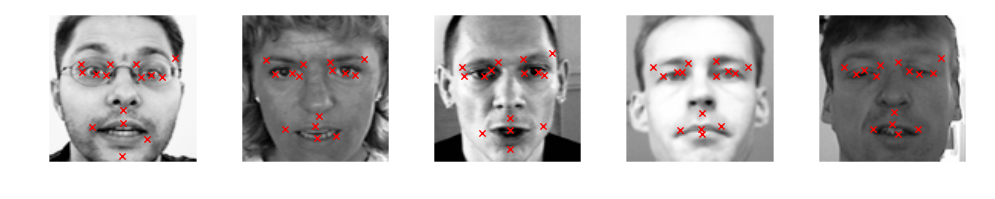

In [28]:
#Visualize 5 example images:
def plot_images(num_images,data, result=None,training=True):
    plt.figure(figsize=(12,4))
    for i in range(num_images):
        img =  np.reshape(data.ix[i:i,"Image"].values[0],(96,96))
        plt.subplot(1,num_images,i+1)
        plt.axis('off')
        plt.imshow(img,cmap='Greys_r')
        #Creating a list of x and y values for keypoints for each image
        #These lists will be used to visualize the keypoints on the images below
        if training==True:
            x_values = np.asarray(data[data.columns.get_level_values(0)[0:30:2]])
            y_values = np.asarray(data[data.columns.get_level_values(0)[1:30:2]])
            plt.scatter(x_values[i],y_values[i])
        if training==False:
            rx_values = np.asarray(result[result.columns.get_level_values(0)[0:30:2]])
            ry_values = np.asarray(result[result.columns.get_level_values(0)[1:30:2]])
            plt.scatter(rx_values[i],ry_values[i],marker="x",color='r')
            

plot_images(5,test,pd.DataFrame(result_test),False)

In [27]:
rt = pd.DataFrame(result_test)
generate_results(rt) 